In [2]:
import pickle
from datetime import datetime
from collections import defaultdict
import rpy2
import pandas as pd
import matplotlib.pyplot as plt
from django.db.models.functions import TruncDay
from pathlib import Path
import pytz
import numpy as np
import seaborn as sns

In [3]:
%load_ext rpy2.ipython

In [4]:
folder = "data/comp1_2020_1/"
Path(folder).mkdir(parents=True, exist_ok=True)

### Get student list

In [6]:
with open("%s/userlogs.pkl" % folder, "rb") as pklfile:
    userlogs = pickle.load(pklfile)

In [7]:
userlogs[0]

{'user__id': 912,
 'problem__id': 838,
 'outcome': 'P',
 'timestamp': datetime.datetime(2020, 12, 7, 17, 13, 38, 320643, tzinfo=<UTC>),
 'user__userprofile__user_class': 30,
 'problem__chapter': 20}

In [8]:
students_list = list(set([log['user__id'] for log in userlogs]))
problems_list = list(set([log['problem__id'] for log in userlogs]))
classes_list = list(set([log['user__userprofile__user_class'] for log in userlogs]))
chapters_list = list(set([log['problem__chapter'] for log in userlogs]))

print(f"Total de alunos: {len(students_list)}")
print(f"Total de problemas: {len(problems_list)}")
print(f"Total de turmas: {len(classes_list)}")
print(f"Total de listas: {len(chapters_list)}")

Total de alunos: 427
Total de problemas: 50
Total de turmas: 15
Total de listas: 9


### Calculate drop-out rate and students submission per week

#### Organize chapter and weeks

In [9]:
c = Chapter.objects.filter(pk__in=chapters_list).values('pk', 'label')
for item in c:
    print(f"{item['pk']} - {item['label']}")

10 - 10 - Dicionário
19 - (PLE) 09 - Laços aninhados e matrizes
20 - (PLE) 02 - Funcoes e Tipos de dados
12 - (PLE) 03 - Tipos de dados, Strings, Estrutura Condicional
13 - (PLE) 04 - Variáveis e atribuição, strings e tuplas
14 - (PLE) 05 - Manipulação de strings, tuplas e listas
15 - (PLE) 06 - Fatiamento e manipulação de listas
16 - (PLE) 07 - Estrutura de repetição com teste de parada: While
17 - (PLE) 08 - Estrutura de repetição iteradora: for


In [10]:
from django.db.models import Case, When

chapter_order = [20, 12, 13, 14, 15, 16, 17, 19, 10]
preserved = Case(*[When(pk=pk, then=pos) for pos, pk in enumerate(chapter_order)])
chapters = Chapter.objects.filter(pk__in=chapter_order).order_by(preserved)

chapter_dict = {}
chapter_start = 2
for idx, item in enumerate(chapters):
    chapter_dict[idx+chapter_start] = item.pk
    print(f"{item.pk} - {item.label}")

20 - (PLE) 02 - Funcoes e Tipos de dados
12 - (PLE) 03 - Tipos de dados, Strings, Estrutura Condicional
13 - (PLE) 04 - Variáveis e atribuição, strings e tuplas
14 - (PLE) 05 - Manipulação de strings, tuplas e listas
15 - (PLE) 06 - Fatiamento e manipulação de listas
16 - (PLE) 07 - Estrutura de repetição com teste de parada: While
17 - (PLE) 08 - Estrutura de repetição iteradora: for
19 - (PLE) 09 - Laços aninhados e matrizes
10 - 10 - Dicionário


In [11]:
def get_chapters(chapters, weeks):
    result = []
    for item in weeks:
        result.append(chapters[item])
    return result

#### Set log query valid dates

In [12]:
students_count = []
data_inicio = datetime.strptime('30/11/2020 00:00:00', '%d/%m/%Y %H:%M:%S')
data_inicio = pytz.timezone("America/Sao_Paulo").localize(data_inicio, is_dst=None)
data_fim = datetime.strptime('06/03/2021 23:59:59', '%d/%m/%Y %H:%M:%S')
data_fim = pytz.timezone("America/Sao_Paulo").localize(data_fim, is_dst=None)

userlog_queryset = UserLog.objects.filter(timestamp__gte=data_inicio, timestamp__lte=data_fim, 
                                          user_id__in=students_list, 
                                          problem__chapter__in=chapters_list)
userlog_queryset.count()

107701

In [11]:
# Count students per week
students_count = []
for c in chapters:
    problems = Problem.objects.filter(chapter=c)
    students = userlog_queryset.filter(problem__in=problems
                                              ).order_by('timestamp'
                                                        ).values_list('user_id', flat=True
                                                                     ).order_by('user_id').distinct()
    students_count.append(students.count())
    
    
# Get students that finished  the last exercises
LAST = [9, 10]
chapter_filter = get_chapters(chapter_dict, LAST)
students = userlog_queryset.filter(problem__chapter__in=chapter_filter
                                              ).order_by('timestamp'
                                                        ).values_list('user_id', flat=True
                                                                     ).order_by('user_id').distinct()
print("Students that submitted in the last 2 weeks: %d" % students.count())

# Get students that finished  the last exercises
LAST = [8, 9, 10]
chapter_filter = get_chapters(chapter_dict, LAST)
students = userlog_queryset.filter(problem__chapter__in=chapter_filter
                                              ).order_by('timestamp'
                                                        ).values_list('user_id', flat=True
                                                                     ).order_by('user_id').distinct()
print("Students that submitted in the last 3 weeks: %d" % students.count())

Students that submitted in the last 2 weeks: 321
Students that submitted in the last 3 weeks: 338


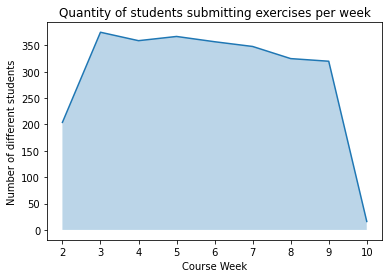

In [12]:
# plt.figure(figsize=(5,4))
plt.plot(range(chapter_start, len(chapter_dict)+chapter_start), students_count)
plt.title("Quantity of students submitting exercises per week")
plt.xlabel("Course Week")
plt.ylabel("Number of different students")
plt.fill_between(range(chapter_start, len(chapter_dict)+chapter_start), students_count, alpha=0.3)
plt.savefig("%s/dropout_rate.png" % folder)
plt.show()

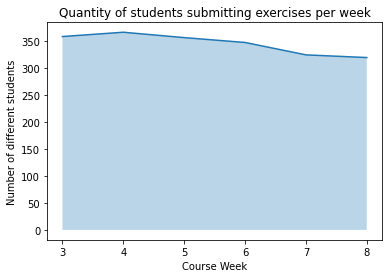

In [13]:
# plt.figure(figsize=(5,4))
plt.plot(range(3, 9), students_count[2:-1])
plt.title("Quantity of students submitting exercises per week")
plt.xlabel("Course Week")
plt.ylabel("Number of different students")
plt.fill_between(range(3, 9), students_count[2:-1], alpha=0.3)
plt.savefig("%s/dropout_rate.png" % folder)
plt.show()

In [14]:
students_count

[204, 375, 359, 367, 357, 348, 325, 320, 16]

In [15]:
%%R
cor.test(c(3:9), c(375, 359, 367, 357, 348, 325, 320))


	Pearson's product-moment correlation

data:  c(3:9) and c(375, 359, 367, 357, 348, 325, 320)
t = -6.099, df = 5, p-value = 0.001716
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9911594 -0.6343112
sample estimates:
       cor 
-0.9388878 



### Features per week

Parameters:
1. Quanto tempo conta para contar como "tentativas"? Até acertar a primeira?
2. 

In [16]:
def get_deadline(outcomes):
    deadline = Deadline.objects.filter(
            onlineclass=outcomes[0].user.userprofile.user_class, chapter=chapter
        ).order_by('-deadline')
    if deadline.count():
        return deadline[0].deadline
    else:
        raise RuntimeError("Chapter does not have deadline")
        
def get_time_to_solution(attempts_queryset):
    total = attempts_queryset.count()
    time_to_solution = attempts_queryset[total-1].timestamp - attempts_queryset[0].timestamp
    return time_to_solution.total_seconds()

def get_on_time_exercises(deadline, attempts_queryset):
    total = attempts_queryset.count()
    if attempts_queryset[total-1].timestamp < deadline:
        return 1
    return 0

In [17]:
%%time

# Using 1st two weeks with student (3 and 4)
data_per_week = defaultdict(dict)
CHAPTERS = [3, 4, 5,6, 8, 9]
chapter_filter = get_chapters(chapter_dict, CHAPTERS)

# For each student
for student in students_list:
#     print(f"student {student}")
    # For each week
    for chapter in chapter_filter:
#         print(f"chapter {chapter}")
        
        # Create features
        attempts = 0
        success_count = 0
        timedelta_to_solution = 0
        timedelta_from_beginning = 0
        on_time_exercises = 0
        
        outcomes = userlog_queryset.filter(user_id=student, 
                                           problem__chapter=chapter
                                          ).order_by('timestamp')
        
        if outcomes.count():
            # Get chapter deadline
            try:
                deadline = get_deadline(outcomes)
            except RuntimeError:
                print(f"Cant find deadline for chapter {chapter} for class {outcomes[0].user.userprofile.user_class}")
    #         print(f"deadline {deadline}")

            # Get timestamp of success
            outcomes_success = outcomes.filter(outcome='P').order_by('problem', 'timestamp')

            # For each correct problem, get number of attempts before success
            if outcomes_success.count():
                current_problem = 0
                for success in outcomes_success:
    #                 print(f"problem {success.problem}")
                    if success.problem != current_problem:
                        attempts_queryset = outcomes.filter(problem=success.problem, timestamp__lte=success.timestamp)

                        # Get attempts statistics
                        problem_attempts = attempts_queryset.count()
                        attempts += problem_attempts
                        success_count += 1
                        timedelta_to_solution += get_time_to_solution(attempts_queryset)
                        timedelta_from_beginning += get_time_to_solution(attempts_queryset) + attempts_queryset[0].seconds_in_page
                        on_time_exercises += get_on_time_exercises(deadline, attempts_queryset)

    #                     print(f"attempts {attempts}")
    #                     print(f"timedelta_to_solution {timedelta_to_solution}")
    #                     print(f"timedelta_from_beginning {timedelta_from_beginning}")
                        current_problem = success.problem
                    else:
                        pass
    #                     print(f"skipping problem {success.problem}")

            # For each wrong problem, just sum failed attempts that were done before deadline
            correct_problems = outcomes_success.values_list('problem', flat=True)
            outcomes_fail = outcomes.filter(timestamp__lte=deadline).exclude(problem__in=correct_problems)

            if outcomes_fail.count():
                print(f"student {student} presented fail outcome")
                attempts += outcomes_fail.count()

        # Get access frequency
        frequency = outcomes.annotate(day=TruncDay('timestamp')
                                     ).values('day').order_by('day').distinct().count()

        data_per_week[student].update({
            f"attempts_{chapter}": attempts,
            f"success_rate_{chapter}": np.float64(success_count)/attempts,
            f"avg_timedelta_to_solution_{chapter}": np.float64(timedelta_to_solution)/success_count,
            f"avg_timedelta_from_beginning_{chapter}": np.float64(timedelta_from_beginning)/success_count,
            f"on_time_exercises_{chapter}": on_time_exercises,
            f"frequency_{chapter}": frequency,
            f"success_count_{chapter}": success_count
        })

student 915 presented fail outcome
student 915 presented fail outcome
student 924 presented fail outcome


<timed exec>:74: RuntimeWarning: invalid value encountered in double_scalars
<timed exec>:75: RuntimeWarning: invalid value encountered in double_scalars


student 931 presented fail outcome
student 937 presented fail outcome


<timed exec>:73: RuntimeWarning: invalid value encountered in double_scalars


student 946 presented fail outcome
student 946 presented fail outcome
student 950 presented fail outcome
student 950 presented fail outcome
student 957 presented fail outcome
student 974 presented fail outcome
student 975 presented fail outcome
student 976 presented fail outcome
student 976 presented fail outcome
student 980 presented fail outcome
student 988 presented fail outcome
student 988 presented fail outcome
student 988 presented fail outcome
student 988 presented fail outcome
student 988 presented fail outcome
student 991 presented fail outcome
student 992 presented fail outcome
student 992 presented fail outcome
student 992 presented fail outcome
student 996 presented fail outcome
student 997 presented fail outcome
student 1000 presented fail outcome
student 1006 presented fail outcome
student 1007 presented fail outcome
student 1007 presented fail outcome
student 1007 presented fail outcome
student 1007 presented fail outcome
student 1013 presented fail outcome
student 1014 

student 1259 presented fail outcome
student 1264 presented fail outcome
student 1264 presented fail outcome
student 1266 presented fail outcome
student 1266 presented fail outcome
student 1266 presented fail outcome
student 1267 presented fail outcome
student 1267 presented fail outcome
student 1272 presented fail outcome
student 1272 presented fail outcome
student 1273 presented fail outcome
student 1273 presented fail outcome
student 1274 presented fail outcome
student 1274 presented fail outcome
student 1274 presented fail outcome
student 1276 presented fail outcome
student 1278 presented fail outcome
student 1278 presented fail outcome
student 1279 presented fail outcome
student 1279 presented fail outcome
student 1281 presented fail outcome
student 1283 presented fail outcome
Cant find deadline for chapter 17 for class Nano-EPT - Jéssica
student 1284 presented fail outcome
student 1284 presented fail outcome
student 1285 presented fail outcome
student 1285 presented fail outcome
s

In [18]:
len(data_per_week)

427

In [18]:
# with open(f'{folder}/dropout_data_per_week_3_6_dict.pkl', 'wb') as pklfile:
#     pickle.dump(data_per_week, pklfile)

In [5]:
with open(f'{folder}/dropout_data_per_week_3_6_dict.pkl', 'rb') as pklfile:
    data_per_week = pickle.load(pklfile)

In [6]:
data_per_week

defaultdict(dict,
            {910: {'attempts_12': 8,
              'success_rate_12': 0.375,
              'avg_timedelta_to_solution_12': 65.38685733333334,
              'avg_timedelta_from_beginning_12': 328.7201906666667,
              'on_time_exercises_12': 3,
              'frequency_12': 1,
              'success_count_12': 3,
              'attempts_13': 24,
              'success_rate_13': 0.2916666666666667,
              'avg_timedelta_to_solution_13': 291.47682314285714,
              'avg_timedelta_from_beginning_13': 601.7625374285715,
              'on_time_exercises_13': 7,
              'frequency_13': 1,
              'success_count_13': 7,
              'attempts_14': 62,
              'success_rate_14': 0.11290322580645161,
              'avg_timedelta_to_solution_14': 615.1183635714285,
              'avg_timedelta_from_beginning_14': 1014.2612207142857,
              'on_time_exercises_14': 7,
              'frequency_14': 2,
              'success_count_14': 7

### Total features

In [13]:
%%time

# Using 1st two weeks with student (3 and 4)
data_total = defaultdict(dict)
FIRST = [3, 4]
chapter_filter = get_chapters(chapter_dict, FIRST)

# For each student
for student in students_list:
#     print(f"student {student}")

    # Create features
    data_total[student] = {
        "attempts": 0,
        "success_rate": 0,
        "avg_timedelta_to_solution": 0,
        "avg_timedelta_from_beginning": 0,
        "on_time_exercises": 0,
        "frequency": 0,
        "success_count": 0
    }
    
    attempts = 0
    success_count = 0
    timedelta_to_solution = 0
    timedelta_from_beginning = 0
    on_time_exercises = 0

    outcomes = userlog_queryset.filter(user_id=student, 
                                       problem__chapter__in=chapter_filter
                                      ).order_by('timestamp')
            
    # Get access frequency
    data_total[student]["frequency"] = outcomes.annotate(day=TruncDay('timestamp')
                                 ).values('day').order_by('day').distinct().count()
    
    for chapter in chapter_filter:
        # Sum weekly feature to get total features
        data_total[student]['attempts'] += data_per_week[student][f"attempts_{chapter}"]
        data_total[student]['success_count'] += data_per_week[student][f"success_count_{chapter}"]
        data_total[student]['on_time_exercises'] += data_per_week[student][f"on_time_exercises_{chapter}"]

        # Recalculate avg values for total features
        data_total[student]['avg_timedelta_to_solution'] += data_per_week[
            student][f"avg_timedelta_to_solution_{chapter}"] * data_per_week[student][f"success_count_{chapter}"]
        data_total[student]['avg_timedelta_from_beginning'] += data_per_week[
            student][f"avg_timedelta_from_beginning_{chapter}"] * data_per_week[student][f"success_count_{chapter}"]
        
#     data_total[student]['total_to_solution'] = data_total[student]['avg_timedelta_to_solution']
#     data_total[student]['total_from_beginning'] = data_total[student]['avg_timedelta_from_beginning']
    data_total[student]['success_rate'] = np.float64(data_total[student]["success_count"])/data_total[student]["attempts"]
    data_total[student]['avg_timedelta_to_solution'] /= data_total[student]["success_count"]
    data_total[student]['avg_timedelta_from_beginning'] /= data_total[student]["success_count"]
#     break    

<timed exec>:49: RuntimeWarning: invalid value encountered in double_scalars


CPU times: user 1.98 s, sys: 28.1 ms, total: 2.01 s
Wall time: 1min 1s


In [14]:
from copy import deepcopy
data_total_and_per_week = deepcopy(data_per_week)

In [15]:
for student in data_total_and_per_week.keys():
    data_total_and_per_week[student].update(data_total[student])

In [16]:
# df_per_week = pd.DataFrame.from_dict(data_per_week, orient='index')
# df_total = pd.DataFrame.from_dict(data_total, orient='index')
df_total_and_per_week = pd.DataFrame.from_dict(data_total_and_per_week, orient='index')

In [19]:
# with open(f'{folder}/dropout_df_total_and_per_week_dict_3_6.pkl', 'wb') as pklfile:
#      pickle.dump(df_total_and_per_week, pklfile)

In [7]:
with open(f'{folder}/dropout_df_total_and_per_week_dict_3_6.pkl', 'rb') as pklfile:
    df_total_and_per_week = pickle.load(pklfile)

In [8]:
df_total_and_per_week.columns

Index(['attempts_12', 'success_rate_12', 'avg_timedelta_to_solution_12',
       'avg_timedelta_from_beginning_12', 'on_time_exercises_12',
       'frequency_12', 'success_count_12', 'attempts_13', 'success_rate_13',
       'avg_timedelta_to_solution_13', 'avg_timedelta_from_beginning_13',
       'on_time_exercises_13', 'frequency_13', 'success_count_13',
       'attempts_14', 'success_rate_14', 'avg_timedelta_to_solution_14',
       'avg_timedelta_from_beginning_14', 'on_time_exercises_14',
       'frequency_14', 'success_count_14', 'attempts_15', 'success_rate_15',
       'avg_timedelta_to_solution_15', 'avg_timedelta_from_beginning_15',
       'on_time_exercises_15', 'frequency_15', 'success_count_15',
       'attempts_17', 'success_rate_17', 'avg_timedelta_to_solution_17',
       'avg_timedelta_from_beginning_17', 'on_time_exercises_17',
       'frequency_17', 'success_count_17', 'attempts_19', 'success_rate_19',
       'avg_timedelta_to_solution_19', 'avg_timedelta_from_beginning_1

In [11]:
df_total_and_per_week.describe()

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,on_time_exercises_19,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count
count,427.000000,354.000000,3.360000e+02,3.360000e+02,427.000000,427.000000,427.000000,427.000000,357.000000,3.530000e+02,...,427.000000,427.000000,427.000000,427.000000,379.000000,3.210000e+02,3.210000e+02,427.000000,427.000000,427.000000
mean,15.749415,0.276748,5.585893e+04,5.775738e+04,1.817330,1.245902,2.210773,37.098361,0.302309,5.774606e+04,...,3.065574,1.407494,4.035129,52.847775,0.252686,6.379628e+04,6.514594e+04,5.306792,3.131148,7.067916
std,28.166681,0.223429,3.157869e+05,3.158571e+05,1.405682,0.862876,1.241904,52.887689,0.264249,1.368085e+05,...,2.813517,1.215217,2.627265,72.227261,0.211998,1.787528e+05,1.787596e+05,4.026558,1.911576,3.706684
min,0.000000,0.000000,0.000000e+00,2.800000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,9.009849e+01,0.000000,0.000000,0.000000
25%,4.000000,0.107143,1.104425e+02,7.357762e+02,0.000000,1.000000,1.000000,7.000000,0.114754,3.689598e+02,...,0.000000,0.500000,0.000000,17.000000,0.106383,6.739452e+02,1.539758e+03,1.000000,2.000000,4.000000
50%,9.000000,0.222222,4.512617e+02,1.479540e+03,3.000000,1.000000,3.000000,20.000000,0.222222,4.805118e+03,...,4.000000,1.000000,6.000000,34.000000,0.192308,8.823278e+03,1.036868e+04,6.000000,3.000000,9.000000
75%,18.000000,0.375000,3.748889e+03,5.400861e+03,3.000000,2.000000,3.000000,44.000000,0.384615,3.967468e+04,...,6.000000,2.000000,6.000000,68.000000,0.339080,5.507646e+04,5.670455e+04,10.000000,4.000000,10.000000
max,439.000000,1.000000,4.853717e+06,4.853822e+06,3.000000,6.000000,3.000000,379.000000,1.000000,1.395349e+06,...,6.000000,6.000000,6.000000,818.000000,1.000000,2.426880e+06,2.426952e+06,10.000000,12.000000,10.000000


### Data transformation and cleaning

In [12]:
exclude = df_total_and_per_week[(df_total_and_per_week['attempts_12'] == 0) & \
                                (df_total_and_per_week['attempts_13'] == 0) & \
                                (df_total_and_per_week['attempts_14'] == 0) & \
                                (df_total_and_per_week['attempts_15'] == 0)]
dtw2 = df_total_and_per_week.drop(index=exclude.index)
dtw2
# exclude

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,on_time_exercises_19,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count
910,8,0.375000,65.386857,328.720191,3,1,3,24,0.291667,291.476823,...,6,1,6,32,0.312500,223.649833,519.849833,10,2,10
911,4,0.750000,132.823499,684.156833,3,1,3,36,0.194444,23916.274449,...,6,2,6,40,0.250000,16781.239164,17381.439164,10,3,10
912,6,0.500000,24.270101,207.270101,3,1,3,7,1.000000,0.000000,...,6,1,6,13,0.769231,7.281030,141.581030,10,2,10
914,9,0.333333,430.621847,918.621847,3,1,3,91,0.076923,40044.526822,...,6,2,6,100,0.100000,28160.355329,28983.855329,10,4,10
915,8,0.375000,124.739469,243.072802,3,1,3,12,0.416667,18.759911,...,5,1,5,20,0.400000,58.502245,167.252245,8,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1400,0,NaN,NaN,NaN,0,3,0,0,NaN,NaN,...,0,0,0,0,NaN,NaN,NaN,0,3,0
1403,0,NaN,NaN,NaN,0,0,0,0,NaN,NaN,...,5,1,5,0,NaN,NaN,NaN,0,0,0
1405,6,0.500000,32.428669,655.095336,0,2,3,22,0.181818,26859.988079,...,0,0,0,28,0.250000,15362.462618,15919.319761,0,7,7
1407,56,0.053571,2124.487458,3170.154125,0,1,3,0,NaN,NaN,...,0,0,0,56,0.053571,NaN,NaN,0,3,3


In [27]:
dtw2.columns

Index(['attempts_12', 'success_rate_12', 'avg_timedelta_to_solution_12',
       'avg_timedelta_from_beginning_12', 'on_time_exercises_12',
       'frequency_12', 'success_count_12', 'attempts_13', 'success_rate_13',
       'avg_timedelta_to_solution_13', 'avg_timedelta_from_beginning_13',
       'on_time_exercises_13', 'frequency_13', 'success_count_13',
       'attempts_14', 'success_rate_14', 'avg_timedelta_to_solution_14',
       'avg_timedelta_from_beginning_14', 'on_time_exercises_14',
       'frequency_14', 'success_count_14', 'attempts_15', 'success_rate_15',
       'avg_timedelta_to_solution_15', 'avg_timedelta_from_beginning_15',
       'on_time_exercises_15', 'frequency_15', 'success_count_15',
       'attempts_17', 'success_rate_17', 'avg_timedelta_to_solution_17',
       'avg_timedelta_from_beginning_17', 'on_time_exercises_17',
       'frequency_17', 'success_count_17', 'attempts_19', 'success_rate_19',
       'avg_timedelta_to_solution_19', 'avg_timedelta_from_beginning_1

In [28]:
dtw2[(dtw2['success_count_17'] >= 3) & (dtw2['success_count_19'] >= 3) ]

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,on_time_exercises_19,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count
910,8,0.375000,65.386857,328.720191,3,1,3,24,0.291667,291.476823,...,6,1,6,32,0.312500,223.649833,519.849833,10,2,10
911,4,0.750000,132.823499,684.156833,3,1,3,36,0.194444,23916.274449,...,6,2,6,40,0.250000,16781.239164,17381.439164,10,3,10
912,6,0.500000,24.270101,207.270101,3,1,3,7,1.000000,0.000000,...,6,1,6,13,0.769231,7.281030,141.581030,10,2,10
914,9,0.333333,430.621847,918.621847,3,1,3,91,0.076923,40044.526822,...,6,2,6,100,0.100000,28160.355329,28983.855329,10,4,10
915,8,0.375000,124.739469,243.072802,3,1,3,12,0.416667,18.759911,...,5,1,5,20,0.400000,58.502245,167.252245,8,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1385,0,NaN,NaN,NaN,0,1,0,62,0.064516,33859.314123,...,5,1,5,62,0.064516,NaN,NaN,4,2,4
1391,0,NaN,NaN,NaN,0,0,0,4,1.000000,0.000000,...,0,2,6,4,1.000000,NaN,NaN,0,1,4
1394,0,NaN,NaN,NaN,0,1,0,22,0.318182,579.336000,...,0,1,6,22,0.318182,NaN,NaN,0,1,7
1395,0,NaN,NaN,NaN,0,0,0,24,0.250000,662.663426,...,0,1,5,24,0.250000,NaN,NaN,0,1,6


<AxesSubplot:>

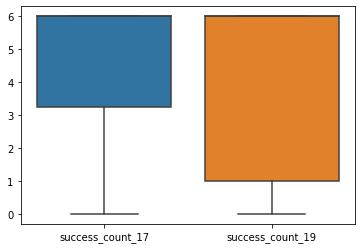

In [29]:
sns.boxplot(data=dtw2[['success_count_17', 'success_count_19']])

In [30]:
284/410

0.6926829268292682

In [31]:
dtw2[['success_count_17', 'success_count_19']].describe()

,success_count_17,success_count_19
count,410.000000,410.000000
mean,4.400000,4.187805
std,2.492237,2.553362
min,0.000000,0.000000
25%,3.250000,1.000000
50%,6.000000,6.000000
75%,6.000000,6.000000
max,6.000000,6.000000


In [32]:
dtw2['success_count_label'] = dtw2['success_count_17'] + dtw2['success_count_19']

/home/lmoraes/.pyenv/versions/machineteaching/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='success_count_label'>

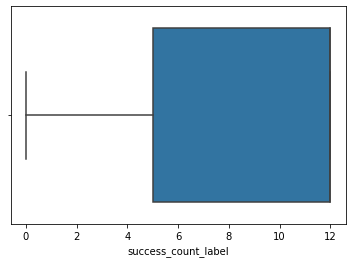

In [33]:
sns.boxplot(dtw2['success_count_label'])

In [34]:
dtw2['success_count_label'].describe()

count    410.000000
mean       8.587805
std        4.802541
min        0.000000
25%        5.000000
50%       12.000000
75%       12.000000
max       12.000000
Name: success_count_label, dtype: float64

In [35]:
dtw2[dtw2['success_count_label'] >= 6]

,attempts_12,success_rate_12,avg_timedelta_to_solution_12,avg_timedelta_from_beginning_12,on_time_exercises_12,frequency_12,success_count_12,attempts_13,success_rate_13,avg_timedelta_to_solution_13,...,frequency_19,success_count_19,attempts,success_rate,avg_timedelta_to_solution,avg_timedelta_from_beginning,on_time_exercises,frequency,success_count,success_count_label
910,8,0.375000,65.386857,328.720191,3,1,3,24,0.291667,291.476823,...,1,6,32,0.312500,223.649833,519.849833,10,2,10,12
911,4,0.750000,132.823499,684.156833,3,1,3,36,0.194444,23916.274449,...,2,6,40,0.250000,16781.239164,17381.439164,10,3,10,12
912,6,0.500000,24.270101,207.270101,3,1,3,7,1.000000,0.000000,...,1,6,13,0.769231,7.281030,141.581030,10,2,10,12
914,9,0.333333,430.621847,918.621847,3,1,3,91,0.076923,40044.526822,...,2,6,100,0.100000,28160.355329,28983.855329,10,4,10,12
915,8,0.375000,124.739469,243.072802,3,1,3,12,0.416667,18.759911,...,1,5,20,0.400000,58.502245,167.252245,8,2,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1391,0,NaN,NaN,NaN,0,0,0,4,1.000000,0.000000,...,2,6,4,1.000000,NaN,NaN,0,1,4,12
1393,0,NaN,NaN,NaN,0,0,0,4,1.000000,0.000000,...,0,0,4,1.000000,NaN,NaN,0,1,4,6
1394,0,NaN,NaN,NaN,0,1,0,22,0.318182,579.336000,...,1,6,22,0.318182,NaN,NaN,0,1,7,12
1395,0,NaN,NaN,NaN,0,0,0,24,0.250000,662.663426,...,1,5,24,0.250000,NaN,NaN,0,1,6,11


In [13]:
305/410

0.7439024390243902

<AxesSubplot:>

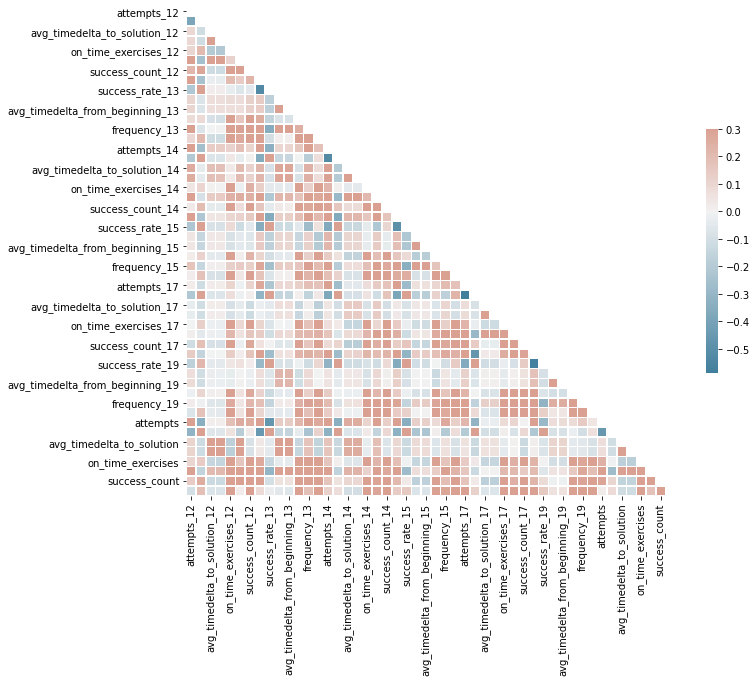

In [198]:
# Compute the correlation matrix
corr = dtw2.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Testando com todas as variáveis de semana

In [37]:
x = dtw2[['attempts_12', 'success_rate_12', 'avg_timedelta_to_solution_12',
       'avg_timedelta_from_beginning_12', 'on_time_exercises_12',
       'frequency_12', 'success_count_12', 'attempts_13', 'success_rate_13',
       'avg_timedelta_to_solution_13', 'avg_timedelta_from_beginning_13',
       'on_time_exercises_13', 'frequency_13', 'success_count_13',
         'attempts_14', 'success_rate_14', 'avg_timedelta_to_solution_14',
       'avg_timedelta_from_beginning_14', 'on_time_exercises_14',
       'frequency_14', 'success_count_14', 'attempts_15', 'success_rate_15',
       'avg_timedelta_to_solution_15', 'avg_timedelta_from_beginning_15',
       'on_time_exercises_15', 'frequency_15', 'success_count_15']]
y = dtw2['success_count_label']

In [38]:
X = x.fillna(value={'success_rate_12': 0, 'success_rate_13': 0,  'success_rate_14': 0,  'success_rate_15': 0, 
                'avg_timedelta_to_solution_12': dtw2.max()['avg_timedelta_to_solution_12'],
                'avg_timedelta_from_beginning_12': dtw2.max()['avg_timedelta_from_beginning_12'],
                'avg_timedelta_to_solution_13': dtw2.max()['avg_timedelta_to_solution_13'],
                'avg_timedelta_from_beginning_13': dtw2.max()['avg_timedelta_from_beginning_13'],
                'avg_timedelta_to_solution_14': dtw2.max()['avg_timedelta_to_solution_14'],
                'avg_timedelta_from_beginning_14': dtw2.max()['avg_timedelta_from_beginning_14'],
                'avg_timedelta_to_solution_15': dtw2.max()['avg_timedelta_to_solution_15'],
                'avg_timedelta_from_beginning_15': dtw2.max()['avg_timedelta_from_beginning_15']
               })

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
model = LinearRegression().fit(X_train, y_train)

In [42]:
model.score(X, y)

0.5968223144081124

In [43]:
y_pred = model.predict(X_test)

In [44]:
mean_squared_error(y_test, y_pred, squared=False)

3.1568907532062376

<AxesSubplot:xlabel='importance', ylabel='column'>

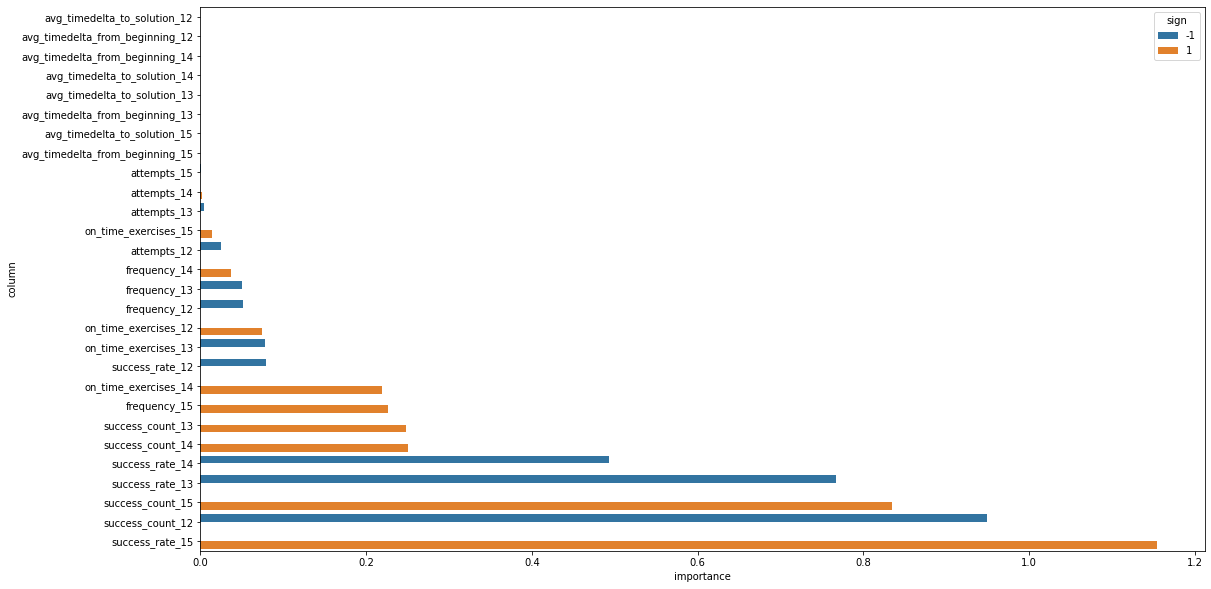

In [93]:
# get importance
raw_importance = model.coef_
importance = abs(raw_importance)
sign = np.vectorize(lambda a: int(a>0) - int(a<0))(raw_importance)
# summarize feature importance
columns = X.columns

df = pd.DataFrame(data=zip(*[columns, importance, sign]), columns=['column', 'importance', 'sign'])

df = df.sort_values('importance')
df.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(data=df, x='importance', y='column', hue='sign', ax=ax)

In [96]:
%%R
library(gdata)
library(rattle)
library(rpart)
library(e1071)
library(tidyverse)
library(caret)

R[write to console]: gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

R[write to console]: 

R[write to console]: gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

R[write to console]: 
Attaching package: ‘gdata’


R[write to console]: The following object is masked from ‘package:stats’:

    nobs


R[write to console]: The following object is masked from ‘package:utils’:

    object.size


R[write to console]: The following object is masked from ‘package:base’:

    startsWith


R[write to console]: Loading required package: tibble

R[write to console]: Loading required package: bitops

R[write to console]: Rattle: A free graphical interface for data science with R.
Version 5.4.0 Copyright (c) 2006-2020 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.

R[write to console]: ── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.3  

In [97]:
df = dtw2

In [98]:
%%R -i df

set.seed(84)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

# priors_false = c(0.6)
max_depth = c(2,3,4,5,6)
recall = c()
f1 = c()
acc = c()
params_prior = c()
params_maxdepth = c()
error = c()
for (md in max_depth){
#   for (p in priors_false) {
#     params_prior = c(params_prior, p)
    params_maxdepth = c(params_maxdepth, md)
#     p_true <- 1 - p
    control <- rpart.control(maxdepth=md)
    model = rpart(formula = success_count_label ~ attempts_12 + success_rate_12 + avg_timedelta_to_solution_12 + 
                  avg_timedelta_from_beginning_12 + on_time_exercises_12 + frequency_12 + success_count_12 + 
                  attempts_13 + success_rate_13 + avg_timedelta_to_solution_13 + avg_timedelta_from_beginning_13 + 
                  on_time_exercises_13 + frequency_13 + success_count_13 + attempts_14 + success_rate_14 + 
                  avg_timedelta_to_solution_14 + avg_timedelta_from_beginning_14 + on_time_exercises_14 + frequency_14 + 
                  success_count_14 + attempts_15 + success_rate_15 + avg_timedelta_to_solution_15 + 
                  avg_timedelta_from_beginning_15 + on_time_exercises_15 + frequency_15 + success_count_15, 
                  data = train, method='anova', 
                  control=control, 
                  parms = list(
#                       prior = c(p, p_true),
                               split = "gini"),
                  xval=10)
    # Prevendo no treino
    train_prediction <- predict(model, newdata=train_s)
    error <- c(error, RMSE(pred = train_prediction, obs = train_true$success_count_label))
#     train_prediction <- as.factor(as.logical(train_prediction))
#     train_true <- as.factor(as.logical(unlist(train_true)))
#     cm <- caret::confusionMatrix(train_prediction, train_true)
#     recall <- c(recall, cm$byClass[6])
#     acc <- c(acc, cm$overall[1])
#     f1 <- c(f1, cm$byClass[7])
#   }
};

print(error)
# print(recall)
# print(f1)
# print(acc)
# print(params_prior)
print(params_maxdepth)
# typeof(test_true$success_count_label)

[1] 3.144172 2.982940 2.942588 2.877698 2.877698
[1] 2 3 4 5 6


### Best models:
1. Prior = 0.6 (NOT COMPLETED) and 0.4 (COMPLETED)
2. Max depth = 3, 4 and 2

[1] 3.687656
      924       938       943       946       948       956       959       966 
11.250000 11.250000 11.250000  6.562500 11.250000  6.562500 11.250000  6.375000 
      972       973       974       979       987      1003      1007      1014 
11.250000 11.250000  9.833333 11.250000 11.250000  6.375000 11.250000 11.250000 
     1015      1025      1026      1032      1035      1036      1046      1047 
 3.783784  3.783784  6.750000 11.250000  6.562500 11.250000 11.250000 11.250000 
     1052      1059      1060      1068      1078      1096      1100      1105 
 3.783784  3.783784 11.250000  1.051282  3.783784 11.250000 11.250000 11.250000 
     1111      1114      1116      1117      1121      1126      1138      1144 
 6.375000  1.051282 11.250000  3.783784 11.250000  9.833333  3.783784 11.250000 
     1152      1154      1156      1160      1166      1179      1184      1188 
 6.562500  9.833333  1.051282  6.375000 11.250000  1.051282 11.250000  6.562500 
     1196      

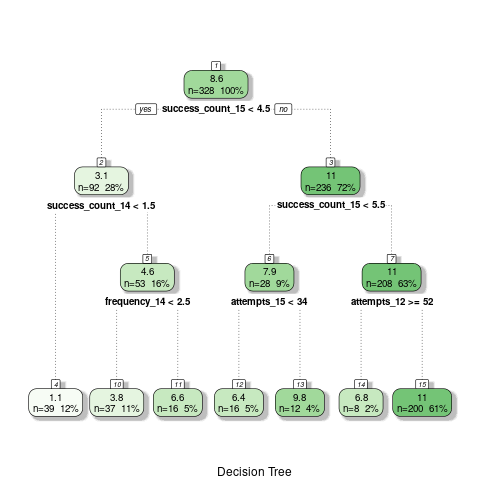

In [101]:
%%R -o cm

set.seed(84)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

control <- rpart.control(maxdepth=3)
model = rpart(formula = success_count_label ~ attempts_12 + success_rate_12 + avg_timedelta_to_solution_12 + 
                  avg_timedelta_from_beginning_12 + on_time_exercises_12 + frequency_12 + success_count_12 + 
                  attempts_13 + success_rate_13 + avg_timedelta_to_solution_13 + avg_timedelta_from_beginning_13 + 
                  on_time_exercises_13 + frequency_13 + success_count_13 + attempts_14 + success_rate_14 + 
                  avg_timedelta_to_solution_14 + avg_timedelta_from_beginning_14 + on_time_exercises_14 + frequency_14 + 
                  success_count_14 + attempts_15 + success_rate_15 + avg_timedelta_to_solution_15 + 
                  avg_timedelta_from_beginning_15 + on_time_exercises_15 + frequency_15 + success_count_15, 
                  data = train, method='anova', 
                  control=control, 
                  parms = list(
#                       prior = c(p, p_true), 
                      split = "gini"),
                  xval=10)

fancyRpartPlot(model,sub="Decision Tree")

# # Prevendo no teste
test_prediction <- predict(model, newdata=test)
error <- RMSE(pred = test_prediction, obs = test_true$success_count_label)

# test_prediction <- as.factor(as.logical(test_prediction))
# test_true <- as.factor(as.logical(unlist(test_true)))
# cm <- caret::confusionMatrix(test_prediction, test_true)
# print(cm)
# print(cm$byClass)
# print(cm$byClass[6])
# print(cm$overall[1])
# print(cm$byClass[7])
print(error)
print(test_prediction)

In [103]:
df = dtw2.fillna(value={'success_rate_12': 0, 'success_rate_13': 0,  'success_rate_14': 0,  'success_rate_15': 0, 
                'avg_timedelta_to_solution_12': dtw2.max()['avg_timedelta_to_solution_12'],
                'avg_timedelta_from_beginning_12': dtw2.max()['avg_timedelta_from_beginning_12'],
                'avg_timedelta_to_solution_13': dtw2.max()['avg_timedelta_to_solution_13'],
                'avg_timedelta_from_beginning_13': dtw2.max()['avg_timedelta_from_beginning_13'],
                'avg_timedelta_to_solution_14': dtw2.max()['avg_timedelta_to_solution_14'],
                'avg_timedelta_from_beginning_14': dtw2.max()['avg_timedelta_from_beginning_14'],
                'avg_timedelta_to_solution_15': dtw2.max()['avg_timedelta_to_solution_15'],
                'avg_timedelta_from_beginning_15': dtw2.max()['avg_timedelta_from_beginning_15']
               })

In [104]:
%%R -i df

set.seed(3213)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

model <- lm(formula = success_count_label ~ attempts_12 + success_rate_12 + avg_timedelta_to_solution_12 + 
                  avg_timedelta_from_beginning_12 + on_time_exercises_12 + frequency_12 + success_count_12 + 
                  attempts_13 + success_rate_13 + avg_timedelta_to_solution_13 + avg_timedelta_from_beginning_13 + 
                  on_time_exercises_13 + frequency_13 + success_count_13 + attempts_14 + success_rate_14 + 
                  avg_timedelta_to_solution_14 + avg_timedelta_from_beginning_14 + on_time_exercises_14 + frequency_14 + 
                  success_count_14 + attempts_15 + success_rate_15 + avg_timedelta_to_solution_15 + 
                  avg_timedelta_from_beginning_15 + on_time_exercises_15 + frequency_15 + success_count_15,
            data = train)

train_prediction <- predict(model, newdata=train_s)
error <- RMSE(pred = train_prediction, obs = train_true$success_count_label)

print(error)
summary(model)

[1] 3.014454

Call:
lm(formula = success_count_label ~ attempts_12 + success_rate_12 + 
    avg_timedelta_to_solution_12 + avg_timedelta_from_beginning_12 + 
    on_time_exercises_12 + frequency_12 + success_count_12 + 
    attempts_13 + success_rate_13 + avg_timedelta_to_solution_13 + 
    avg_timedelta_from_beginning_13 + on_time_exercises_13 + 
    frequency_13 + success_count_13 + attempts_14 + success_rate_14 + 
    avg_timedelta_to_solution_14 + avg_timedelta_from_beginning_14 + 
    on_time_exercises_14 + frequency_14 + success_count_14 + 
    attempts_15 + success_rate_15 + avg_timedelta_to_solution_15 + 
    avg_timedelta_from_beginning_15 + on_time_exercises_15 + 
    frequency_15 + success_count_15, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2697  -0.7266   0.5347   1.5003   8.7560 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      5.139e+00  1.516e+00   3.389 0.000795 *

## Removendo attempts and avg_time

In [177]:
x = dtw2[['success_rate_12', 'on_time_exercises_12',
       'frequency_12', 'success_count_12', 'success_rate_13',
       'on_time_exercises_13', 'frequency_13', 'success_count_13',
       'success_rate_14', 'on_time_exercises_14',
       'frequency_14', 'success_count_14', 'success_rate_15',
       'on_time_exercises_15', 'frequency_15', 'success_count_15']]
y = dtw2['success_count_label']

In [178]:
X = x.fillna(value={'success_rate_12': 0, 'success_rate_13': 0,  'success_rate_14': 0,  'success_rate_15': 0})

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [180]:
model = LinearRegression().fit(X_train, y_train)

In [181]:
model.score(X, y)

0.5752506452183761

In [182]:
y_pred = model.predict(X_test)

In [183]:
mean_squared_error(y_test, y_pred, squared=False)

3.112895924055383

<AxesSubplot:xlabel='importance', ylabel='column'>

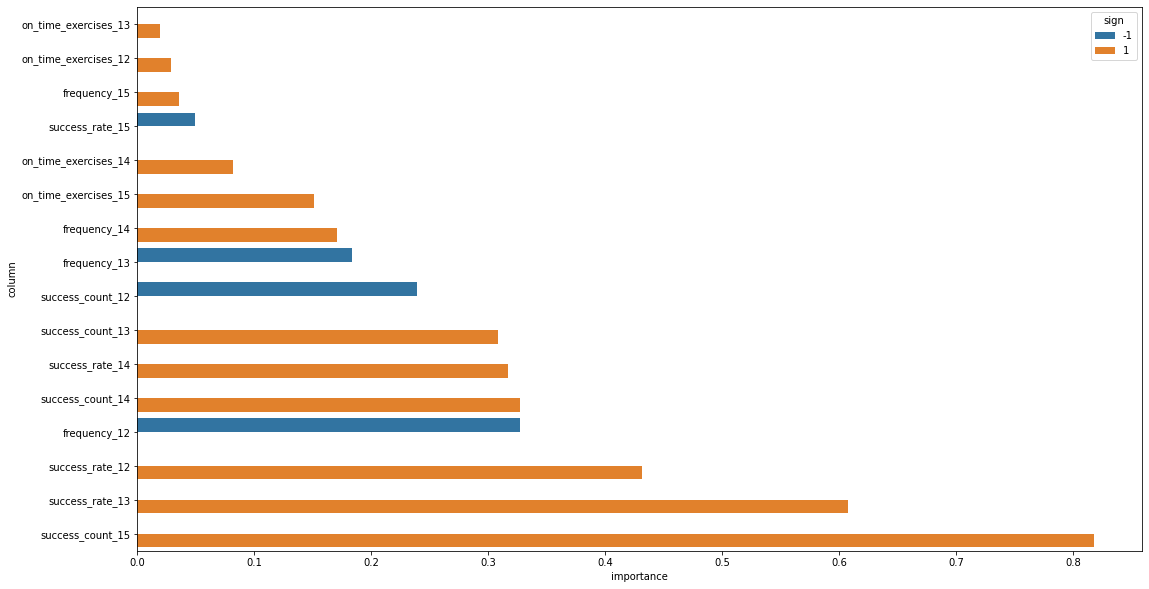

In [184]:
# get importance
raw_importance = model.coef_
importance = abs(raw_importance)
sign = np.vectorize(lambda a: int(a>0) - int(a<0))(raw_importance)
# summarize feature importance
columns = X.columns

df = pd.DataFrame(data=zip(*[columns, importance, sign]), columns=['column', 'importance', 'sign'])

df = df.sort_values('importance')
df.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(data=df, x='importance', y='column', hue='sign', ax=ax)

In [113]:
df = dtw2.fillna(value={'success_rate_12': 0, 'success_rate_13': 0,  'success_rate_14': 0,  'success_rate_15': 0})

In [134]:
%%R -i df -o model -o result

set.seed(3213)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

model <- lm(formula = success_count_label ~ success_rate_12 + on_time_exercises_12 + frequency_12 + success_count_12 + 
                                            success_rate_13 + on_time_exercises_13 + frequency_13 + success_count_13 + 
                                            success_rate_14 + on_time_exercises_14 + frequency_14 + success_count_14 + 
                                            success_rate_15 + on_time_exercises_15 + frequency_15 + success_count_15,
            data = train)

train_prediction <- predict(model, newdata=train_s)
error <- RMSE(pred = train_prediction, obs = train_true$success_count_label)

print(error)
result <- summary(model)
summary(model)

[1] 3.137002

Call:
lm(formula = success_count_label ~ success_rate_12 + on_time_exercises_12 + 
    frequency_12 + success_count_12 + success_rate_13 + on_time_exercises_13 + 
    frequency_13 + success_count_13 + success_rate_14 + on_time_exercises_14 + 
    frequency_14 + success_count_14 + success_rate_15 + on_time_exercises_15 + 
    frequency_15 + success_count_15, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.5077  -0.8197   0.4971   1.4348   9.4948 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)           0.76809    0.56705   1.355   0.1765    
success_rate_12       1.23033    0.97878   1.257   0.2097    
on_time_exercises_12  0.08071    0.20422   0.395   0.6930    
frequency_12         -0.14303    0.24100  -0.594   0.5533    
success_count_12     -0.29907    0.28232  -1.059   0.2903    
success_rate_13       0.90571    0.77763   1.165   0.2450    
on_time_exercises_13  0.06879    0.11132   0.618   0.5371  

In [187]:
def get_index(result, attr):
    for idx, name in enumerate(result.names):
        if name == attr:
            return idx
idx = get_index(result, 'coefficients')
values = list(result[idx])

data = np.reshape(values, (4, int(len(list(result[idx]))/4)))
lm_df = pd.DataFrame(data=data.T, columns=['estimate', 'std err', 't value', 'p-value'], index=['intercept'] + list(x.columns))
lm_df

,estimate,std err,t value,p-value
intercept,0.768093,0.567051,1.354540,1.765474e-01
success_rate_12,1.230332,0.978782,1.257003,2.096959e-01
on_time_exercises_12,0.080713,0.204224,0.395217,6.929536e-01
frequency_12,-0.143035,0.240997,-0.593512,5.532697e-01
success_count_12,-0.299068,0.282322,-1.059316,2.902781e-01
success_rate_13,0.905708,0.777635,1.164696,2.450348e-01
on_time_exercises_13,0.068790,0.111323,0.617935,5.370701e-01
frequency_13,-0.047605,0.162350,-0.293225,7.695457e-01
success_count_13,0.236119,0.140905,1.675735,9.479505e-02
success_rate_14,-0.723277,0.970278,-0.745433,4.565733e-01


<AxesSubplot:xlabel='importance', ylabel='index'>

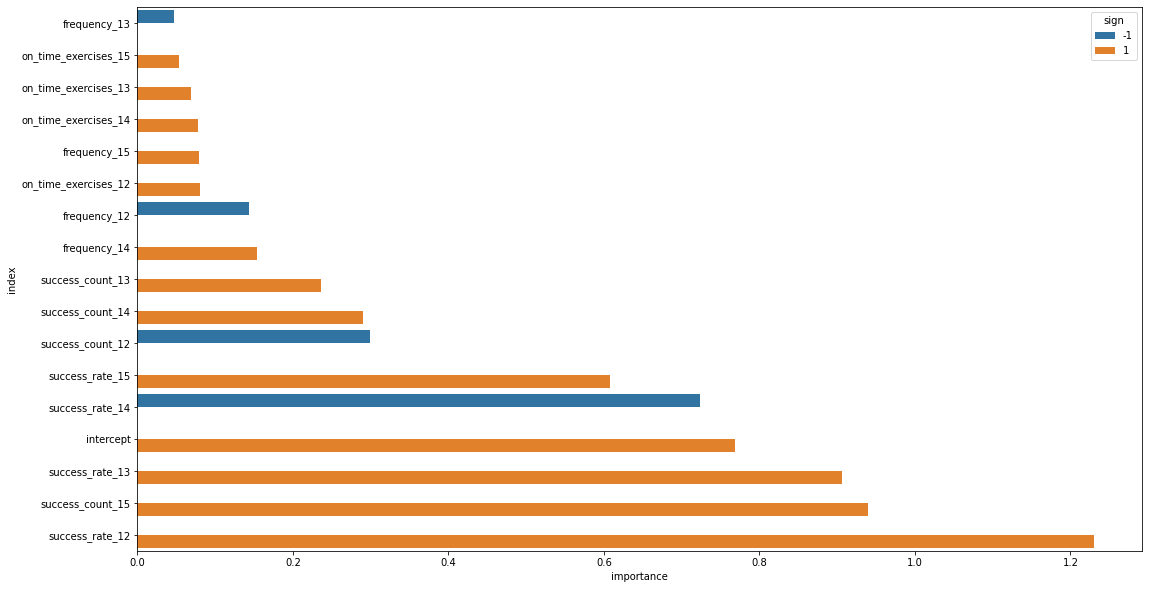

In [194]:
# get importance
lm_df['importance'] = lm_df.apply(lambda row: abs(row['estimate']), axis=1)
lm_df['sign'] = lm_df.apply(lambda row: np.vectorize(lambda a: int(a>0) - int(a<0))(row['estimate']), axis=1)
lm_df['sign'] = lm_df['sign'].astype('int')
# summarize feature importance

df = lm_df.sort_values('importance')
df = df.reset_index()

fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(data=df, x='importance', y='index', hue='sign', ax=ax)

## Mantendo success_rate and success_count

In [199]:
x = dtw2[['success_rate_12', 'success_count_12', 
          'success_rate_13', 'success_count_13',
          'success_rate_14', 'success_count_14', 
          'success_rate_15', 'success_count_15']]
y = dtw2['success_count_label']

In [201]:
X = x.fillna(value={'success_rate_12': 0, 'success_rate_13': 0,  'success_rate_14': 0,  'success_rate_15': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression().fit(X_train, y_train)
model.score(X, y)

0.5651546874438096

In [202]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

3.280247481642212

<AxesSubplot:xlabel='importance', ylabel='column'>

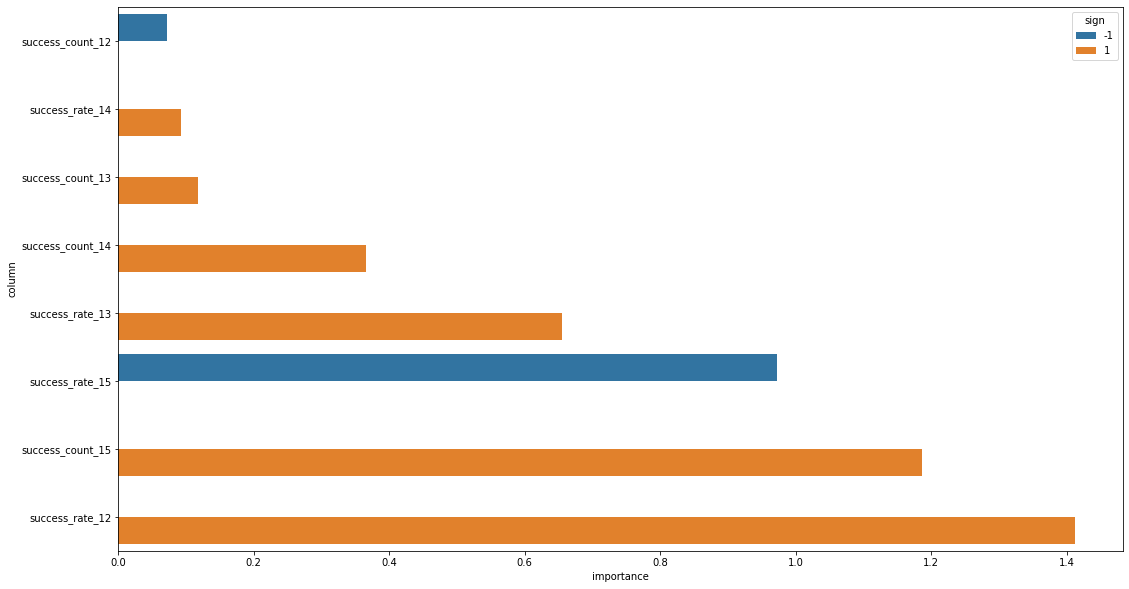

In [203]:
# get importance
raw_importance = model.coef_
importance = abs(raw_importance)
sign = np.vectorize(lambda a: int(a>0) - int(a<0))(raw_importance)
# summarize feature importance
columns = X.columns

df = pd.DataFrame(data=zip(*[columns, importance, sign]), columns=['column', 'importance', 'sign'])

df = df.sort_values('importance')
df.reset_index(drop=True)

fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(data=df, x='importance', y='column', hue='sign', ax=ax)

In [205]:
df = dtw2.fillna(value={'success_rate_12': 0, 'success_rate_13': 0,  'success_rate_14': 0,  'success_rate_15': 0})

In [206]:
%%R -i df -o model -o result

set.seed(3213)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

model <- lm(formula = success_count_label ~ success_rate_12 + success_count_12 + 
                                            success_rate_13 + success_count_13 + 
                                            success_rate_14 + success_count_14 + 
                                            success_rate_15 + success_count_15,
            data = train)

train_prediction <- predict(model, newdata=train_s)
error <- RMSE(pred = train_prediction, obs = train_true$success_count_label)

print(error)
result <- summary(model)
summary(model)

[1] 3.17335

Call:
lm(formula = success_count_label ~ success_rate_12 + success_count_12 + 
    success_rate_13 + success_count_13 + success_rate_14 + success_count_14 + 
    success_rate_15 + success_count_15, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.6865  -0.7169   0.7208   1.1974   9.5969 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.6507     0.5103   1.275 0.203144    
success_rate_12    1.2389     0.9462   1.309 0.191373    
success_count_12  -0.2257     0.2114  -1.068 0.286444    
success_rate_13    0.8198     0.7575   1.082 0.279975    
success_count_13   0.2292     0.1106   2.071 0.039134 *  
success_rate_14   -0.8773     0.9573  -0.916 0.360127    
success_count_14   0.3751     0.1092   3.436 0.000669 ***
success_rate_15    0.3067     1.0040   0.306 0.760176    
success_count_15   1.0745     0.1203   8.930  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual

In [207]:
idx = get_index(result, 'coefficients')
values = list(result[idx])

data = np.reshape(values, (4, int(len(list(result[idx]))/4)))
lm_df = pd.DataFrame(data=data.T, columns=['estimate', 'std err', 't value', 'p-value'], index=['intercept'] + list(x.columns))
lm_df

,estimate,std err,t value,p-value
intercept,0.650749,0.510287,1.275263,2.031443e-01
success_rate_12,1.238920,0.946241,1.309307,1.913728e-01
success_count_12,-0.225733,0.211411,-1.067742,2.864441e-01
success_rate_13,0.819776,0.757500,1.082213,2.799754e-01
success_count_13,0.229151,0.110631,2.071308,3.913367e-02
success_rate_14,-0.877305,0.957294,-0.916444,3.601266e-01
success_count_14,0.375138,0.109191,3.435612,6.694516e-04
success_rate_15,0.306744,1.004034,0.305512,7.601755e-01
success_count_15,1.074533,0.120328,8.930000,3.448948e-17


<AxesSubplot:xlabel='importance', ylabel='index'>

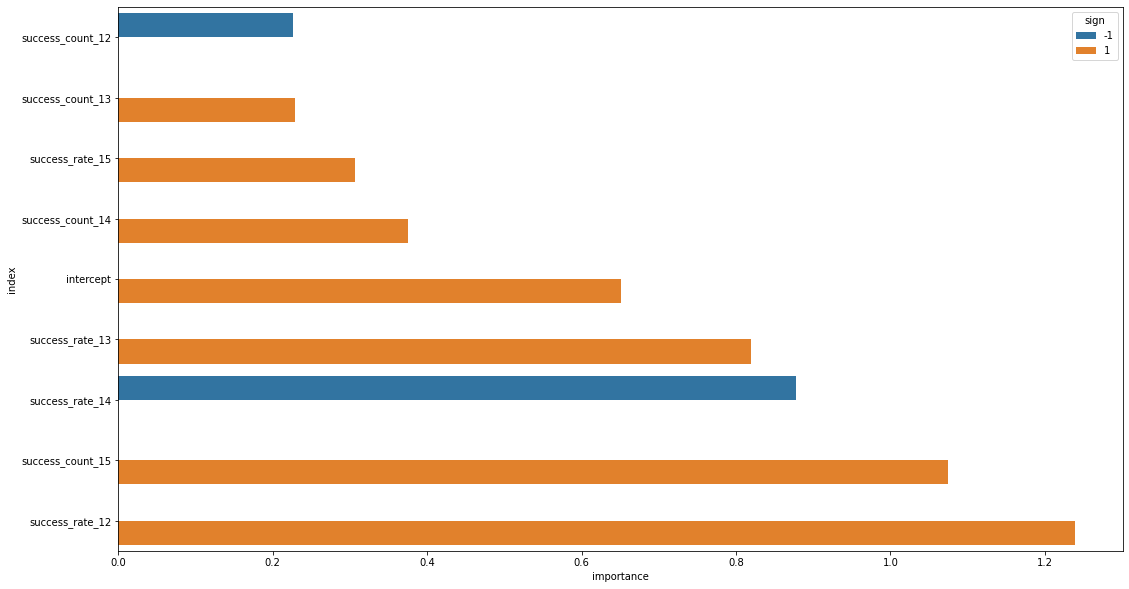

In [208]:
# get importance
lm_df['importance'] = lm_df.apply(lambda row: abs(row['estimate']), axis=1)
lm_df['sign'] = lm_df.apply(lambda row: np.vectorize(lambda a: int(a>0) - int(a<0))(row['estimate']), axis=1)
lm_df['sign'] = lm_df['sign'].astype('int')
# summarize feature importance

df = lm_df.sort_values('importance')
df = df.reset_index()

fig, ax = plt.subplots(figsize=(18,10))
sns.barplot(data=df, x='importance', y='index', hue='sign', ax=ax)

### Testando somente com as agrupadas

In [214]:
df = dtw2.fillna(value={'success_rate': 0,
                'avg_timedelta_to_solution': dtw2.max()['avg_timedelta_to_solution'],
                'avg_timedelta_from_beginning': dtw2.max()['avg_timedelta_from_beginning']
               })

In [215]:
%%R -i df -o model -o result

set.seed(3213)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

model <- lm(formula = success_count_label ~ attempts + success_rate + avg_timedelta_to_solution + 
                                            avg_timedelta_from_beginning + on_time_exercises +
                                            frequency + success_count,
            data = train)

train_prediction <- predict(model, newdata=train_s)
error <- RMSE(pred = train_prediction, obs = train_true$success_count_label)

print(error)
result <- summary(model)
summary(model)tempts                     -8.524e-03  4.242e-03  -2.009  0.04534 *  
success_rate                 -1.077e+00  1.243e+00  -0.867  0.38684    
avg_timedelta_to_solution     1.008e-04  5.091e-05   1.980  0.04855 *  
avg_timedelta_from_beginning -1.003e-04  5.092e-05  -1.970  0.04969 *  
on_time_exercises             2.831e-01  7.984e-02   3.546  0.00045 ***
frequency                    -1.065e-01  1.629e-01  -0.654  0.51379    
success_count 

[1] 3.923906

Call:
lm(formula = success_count_label ~ attempts + success_rate + 
    avg_timedelta_to_solution + avg_timedelta_from_beginning + 
    on_time_exercises + frequency + success_count, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.2066  -2.5456   0.6351   2.3548   9.2324 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   2.237e+00  1.038e+00   2.155  0.03188 *  
attempts                     -8.524e-03  4.242e-03  -2.009  0.04534 *  
success_rate                 -1.077e+00  1.243e+00  -0.867  0.38684    
avg_timedelta_to_solution     1.008e-04  5.091e-05   1.980  0.04855 *  
avg_timedelta_from_beginning -1.003e-04  5.092e-05  -1.970  0.04969 *  
on_time_exercises             2.831e-01  7.984e-02   3.546  0.00045 ***
frequency                    -1.065e-01  1.629e-01  -0.654  0.51379    
success_count                 7.539e-01  1.351e-01   5.579 5.15e-08 ***
---
Signif. codes:  0 

### Testando semanais e agrupadas

In [216]:
df = dtw2.fillna(value={'success_rate_12': 0, 'success_rate_13': 0,  'success_rate_14': 0,  'success_rate_15': 0, 
                'avg_timedelta_to_solution_12': dtw2.max()['avg_timedelta_to_solution_12'],
                'avg_timedelta_from_beginning_12': dtw2.max()['avg_timedelta_from_beginning_12'],
                'avg_timedelta_to_solution_13': dtw2.max()['avg_timedelta_to_solution_13'],
                'avg_timedelta_from_beginning_13': dtw2.max()['avg_timedelta_from_beginning_13'],
                'avg_timedelta_to_solution_14': dtw2.max()['avg_timedelta_to_solution_14'],
                'avg_timedelta_from_beginning_14': dtw2.max()['avg_timedelta_from_beginning_14'],
                'avg_timedelta_to_solution_15': dtw2.max()['avg_timedelta_to_solution_15'],
                'avg_timedelta_from_beginning_15': dtw2.max()['avg_timedelta_from_beginning_15'],
                        'success_rate': 0,
                'avg_timedelta_to_solution': dtw2.max()['avg_timedelta_to_solution'],
                'avg_timedelta_from_beginning': dtw2.max()['avg_timedelta_from_beginning']
               })

In [221]:
%%R -i df -o model -o result

set.seed(454)
nrows <- nrow(df)
ntrain <- sample(nrows, round(nrows*0.8))
train <- df[ntrain,]
test_all <- df[-ntrain,]
test <- test_all %>% select(-success_count_label)
test_true <- test_all %>% select(success_count_label)
train_s <- train %>% select(-success_count_label)
train_true <- train %>% select(success_count_label)

model <- lm(formula = success_count_label ~ success_rate_12 + success_count_12 + 
                                            success_rate_13 + success_count_13 + 
                                            success_rate_14 + success_count_14 + 
                                            success_rate_15 + success_count_15 + attempts +
                  success_rate + avg_timedelta_to_solution + avg_timedelta_from_beginning + on_time_exercises +
                  frequency + success_count,
            data = train)

train_prediction <- predict(model, newdata=train_s)
error <- RMSE(pred = train_prediction, obs = train_true$success_count_label)

print(error)
result <- summary(model)
summary(model)

[1] 2.989304

Call:
lm(formula = success_count_label ~ success_rate_12 + success_count_12 + 
    success_rate_13 + success_count_13 + success_rate_14 + success_count_14 + 
    success_rate_15 + success_count_15 + attempts + success_rate + 
    avg_timedelta_to_solution + avg_timedelta_from_beginning + 
    on_time_exercises + frequency + success_count, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-11.9164  -0.8205   0.5872   1.1947   8.9575 

Coefficients: (1 not defined because of singularities)
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   2.724e+00  1.147e+00   2.376   0.0181 *  
success_rate_12               7.827e-01  1.272e+00   0.615   0.5388    
success_count_12             -5.400e-01  2.973e-01  -1.817   0.0702 .  
success_rate_13               3.648e-01  1.342e+00   0.272   0.7859    
success_count_13              1.763e-01  1.304e-01   1.352   0.1775    
success_rate_14              -1.284e+00

In [ ]:
quantos_exercicios_vai_fazer_nas_semanas_8_e_9 = peso_da_variavel_1 * valor_da_variavel_1 + peso_da_variavel_2 * valor_da_variavel_2 + ...